# 01 - Analise Exploratoria de Dados (EDA)

Pipeline completo: Carga do banco -> Validacao -> Filtro temporal -> Feature engineering -> Selecao de features

**Saidas:**
- `output/data/raw_sensor_data_YYYYMMDD_HHMMSS.csv` (backup dos dados brutos)
- `output/data/features_extracted_YYYYMMDD_HHMMSS.csv` (dataset de features)
- `output/data/features_latest.csv` (copia latest para notebook 02)
- `output/metrics/analise_exploratoria_summary.json`
- `config/feature_config.json` (features selecionadas + parametros)
- Figuras interativas em `output/figures/`

In [ ]:
# =============================================================================
# Celula 1: Configuracao e Imports
# =============================================================================
import os
import json
import warnings
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from scipy import stats as scipy_stats
from scipy.stats import skew, kurtosis, kruskal
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pymysql

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# --- CONFIGURACAO ---
DB_CONFIG = {
    'host': 'localhost',
    'user': 'root',
    'password': '',
    'database': 'iot_mpu6050',
}

# Taxa de amostragem
SAMPLE_RATE_HZ = 5   # Taxa configurada no ESP32 (5 Hz)

# Feature engineering
WINDOW_SIZE = 100    # pontos por janela (= 20s a 5Hz)
STEP_SIZE = 20       # stride da janela deslizante (= 4s a 5Hz)

# Feature selection
ANOVA_ALPHA = 0.05
CORRELATION_THRESHOLD = 0.85

# Eixos do sensor
SENSOR_AXES = ['accel_x_g', 'accel_y_g', 'accel_z_g', 'gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps']

# Paths
TIMESTAMP_STR = datetime.now().strftime('%Y%m%d_%H%M%S')
OUTPUT_DATA = 'output/data'
OUTPUT_FIGURES = 'output/figures'
OUTPUT_METRICS = 'output/metrics'
CONFIG_DIR = os.path.join('..', 'config')

for d in [OUTPUT_DATA, OUTPUT_FIGURES, OUTPUT_METRICS, CONFIG_DIR]:
    os.makedirs(d, exist_ok=True)

print(f'Timestamp: {TIMESTAMP_STR}')
print(f'Sample Rate: {SAMPLE_RATE_HZ} Hz')
print(f'Window: {WINDOW_SIZE} pontos = {WINDOW_SIZE/SAMPLE_RATE_HZ:.0f}s, Step: {STEP_SIZE} pontos = {STEP_SIZE/SAMPLE_RATE_HZ:.0f}s')
print(f'Figuras: {os.path.abspath(OUTPUT_FIGURES)}')
print(f'Metricas: {os.path.abspath(OUTPUT_METRICS)}')

In [2]:
# =============================================================================
# Celula 2: Carga do banco de dados
# =============================================================================
conn = pymysql.connect(**DB_CONFIG)

query = """
SELECT id, timestamp, temperature, vibration,
       accel_x_g, accel_y_g, accel_z_g,
       gyro_x_dps, gyro_y_dps, gyro_z_dps,
       fan_state, collection_id
FROM sensor_data
WHERE fan_state IN ('LOW', 'MEDIUM', 'HIGH')
ORDER BY timestamp ASC
"""

df_raw = pd.read_sql(query, conn)
conn.close()

print(f'Total de amostras carregadas: {len(df_raw)}')
print(f'Classes: {df_raw["fan_state"].value_counts().to_dict()}')
print(f'Collections: {df_raw["collection_id"].nunique()}')
df_raw.head()

Total de amostras carregadas: 7710
Classes: {'LOW': 2695, 'HIGH': 2510, 'MEDIUM': 2505}
Collections: 1


,id,timestamp,temperature,vibration,accel_x_g,accel_y_g,accel_z_g,gyro_x_dps,gyro_y_dps,gyro_z_dps,fan_state,collection_id
0,90,1.769871e+09,26.7418,7.33588,0.253662,0.111572,-1.09595,-0.412214,0.374046,-6.54962,LOW,v5_stream
1,91,1.769871e+09,26.6947,6.61069,0.269531,0.114502,-1.09717,-1.519080,-0.931298,-4.16031,LOW,v5_stream
2,92,1.769871e+09,26.7888,3.57252,0.218506,0.137451,-1.07520,0.328244,2.145040,1.09924,LOW,v5_stream
3,93,1.769871e+09,26.6947,6.83206,0.279541,0.103760,-1.08350,-1.198470,-0.267176,-5.36641,LOW,v5_stream
4,94,1.769871e+09,26.6947,4.70992,0.269531,0.076416,-1.09351,-1.671760,0.641221,2.39695,LOW,v5_stream


In [ ]:
# =============================================================================
# Celula 3: Salvar dados brutos em CSV (backup do banco) com timestamp legivel
# =============================================================================
# Adicionar timestamp ISO 8601 legivel
df_raw['timestamp_iso'] = pd.to_datetime(df_raw['timestamp'], unit='s', utc=True).dt.strftime('%Y-%m-%dT%H:%M:%S.%fZ')

raw_csv_path = os.path.join(OUTPUT_DATA, f'raw_sensor_data_{TIMESTAMP_STR}.csv')
df_raw.to_csv(raw_csv_path, index=False)
print(f'Dados brutos salvos em: {raw_csv_path}')
print(f'Shape: {df_raw.shape}')
print(f'Colunas: {list(df_raw.columns)}')
print(f'Exemplo timestamp_iso: {df_raw["timestamp_iso"].iloc[0]}')

In [4]:
# =============================================================================
# Celula 4: Validacao e estatisticas gerais
# =============================================================================
print('=== INFO ===')
df_raw.info()
print()
print('=== NULLS ===')
print(df_raw.isnull().sum())
print()
print('=== DESCRIBE ===')
df_raw[SENSOR_AXES].describe()

=== INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7710 entries, 0 to 7709
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7710 non-null   int64  
 1   timestamp      7710 non-null   float64
 2   temperature    7710 non-null   float64
 3   vibration      7710 non-null   float64
 4   accel_x_g      7710 non-null   float64
 5   accel_y_g      7710 non-null   float64
 6   accel_z_g      7710 non-null   float64
 7   gyro_x_dps     7710 non-null   float64
 8   gyro_y_dps     7710 non-null   float64
 9   gyro_z_dps     7710 non-null   float64
 10  fan_state      7710 non-null   object 
 11  collection_id  7710 non-null   object 
dtypes: float64(9), int64(1), object(2)
memory usage: 722.9+ KB

=== NULLS ===
id               0
timestamp        0
temperature      0
vibration        0
accel_x_g        0
accel_y_g        0
accel_z_g        0
gyro_x_dps       0
gyro_y_dps       0
gyro_z_dps    

,accel_x_g,accel_y_g,accel_z_g,gyro_x_dps,gyro_y_dps,gyro_z_dps
count,7710.000000,7710.000000,7710.000000,7710.000000,7710.000000,7710.000000
mean,0.288086,-0.019154,-1.082838,-0.965162,0.611869,1.117392
std,0.107309,0.137098,0.028919,1.241966,2.552809,15.607034
min,-0.181152,-0.436768,-1.226810,-5.740460,-9.000000,-45.969500
25%,0.241943,-0.125488,-1.096190,-1.702290,-0.839695,-9.990460
50%,0.290283,-0.016113,-1.082520,-0.984733,0.557252,1.248090
75%,0.340576,0.087891,-1.069090,-0.208015,1.916030,11.717600
max,0.729492,0.401367,-0.958984,4.389310,14.068700,44.137400


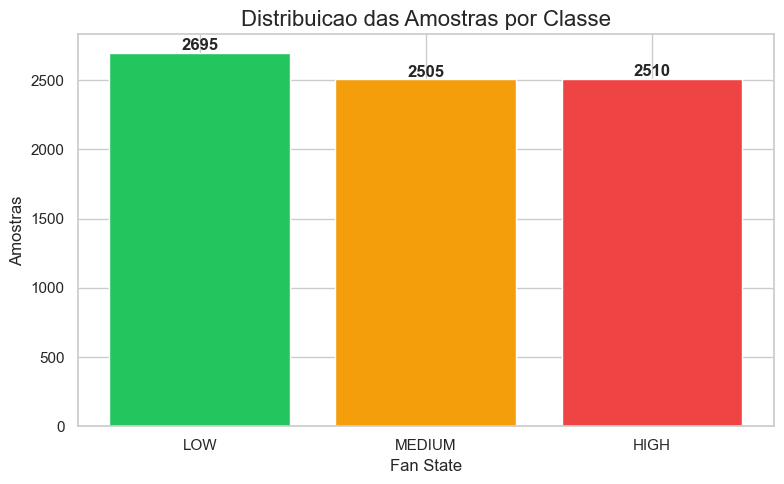

fan_state
LOW       2695
HIGH      2510
MEDIUM    2505
Name: count, dtype: int64


In [5]:
# =============================================================================
# Celula 5: Distribuicao de classes (barplot)
# =============================================================================
class_counts = df_raw['fan_state'].value_counts()

fig, ax = plt.subplots(figsize=(8, 5))
colors = {'LOW': '#22c55e', 'MEDIUM': '#f59e0b', 'HIGH': '#ef4444'}
order = ['LOW', 'MEDIUM', 'HIGH']
bar_colors = [colors[c] for c in order]
counts_ordered = [class_counts.get(c, 0) for c in order]

ax.bar(order, counts_ordered, color=bar_colors)
ax.set_title('Distribuicao das Amostras por Classe', fontsize=16)
ax.set_xlabel('Fan State')
ax.set_ylabel('Amostras')
for i, v in enumerate(counts_ordered):
    ax.text(i, v + 20, str(v), ha='center', fontweight='bold')
plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_FIGURES, '01_distribuicao_classes.png'), dpi=150)
plt.show()
print(class_counts)

In [ ]:
# =============================================================================
# Celula 6: Normalizacao do tempo relativo por classe + taxa real
# =============================================================================
df_raw['timestamp_s'] = df_raw['timestamp'].copy()
# Se timestamp estiver em ms, converter para s
if df_raw['timestamp_s'].median() > 1e12:
    df_raw['timestamp_s'] = df_raw['timestamp_s'] / 1000.0

# Tempo relativo por classe (segundos desde o inicio da coleta daquela classe)
df_raw['relative_time_s'] = 0.0
for cls in df_raw['fan_state'].unique():
    mask = df_raw['fan_state'] == cls
    t0 = df_raw.loc[mask, 'timestamp_s'].min()
    df_raw.loc[mask, 'relative_time_s'] = df_raw.loc[mask, 'timestamp_s'] - t0

# Duracao e taxa real por classe
duration_per_class = df_raw.groupby('fan_state')['relative_time_s'].max()
samples_per_class = df_raw.groupby('fan_state').size()

print('=== Duracao por classe (s) ===')
print(duration_per_class)
print()
print(f'Amostras por classe: {samples_per_class.to_dict()}')
print()
print('=== Taxa real de amostragem (Hz) ===')
for cls in ['LOW', 'MEDIUM', 'HIGH']:
    real_rate = samples_per_class[cls] / duration_per_class[cls]
    print(f'  {cls}: {real_rate:.2f} Hz (configurada: {SAMPLE_RATE_HZ} Hz)')

In [7]:
# =============================================================================
# Celula 7: Calculo da janela de tempo comum
# =============================================================================
common_window_s = duration_per_class.min()
print(f'Janela de tempo comum: {common_window_s:.2f} s')
print(f'Isso corresponde a ~{common_window_s/60:.1f} minutos')

Janela de tempo comum: 639.89 s
Isso corresponde a ~10.7 minutos


In [8]:
# =============================================================================
# Celula 8: FILTRO TEMPORAL - recortar TODAS as classes pela janela comum
# ANTES de qualquer analise posterior (graficos E features)
# =============================================================================
df = df_raw[df_raw['relative_time_s'] <= common_window_s].copy()

print(f'Amostras ANTES do filtro: {len(df_raw)}')
print(f'Amostras APOS o filtro:  {len(df)}')
print(f'Amostras por classe (filtrado): {df.groupby("fan_state").size().to_dict()}')
print(f'Duracao por classe (filtrado):')
print(df.groupby('fan_state')['relative_time_s'].max())

Amostras ANTES do filtro: 7710
Amostras APOS o filtro:  7513
Amostras por classe (filtrado): {'HIGH': 2493, 'LOW': 2515, 'MEDIUM': 2505}
Duracao por classe (filtrado):
fan_state
HIGH      639.1062
LOW       639.6797
MEDIUM    639.8901
Name: relative_time_s, dtype: float64


In [9]:
# =============================================================================
# Celula 9: Graficos interativos individuais (Plotly) - dados filtrados
# =============================================================================
print('Gerando graficos individuais por eixo...')

for axis in SENSOR_AXES:
    fig = px.line(
        df, x='relative_time_s', y=axis,
        color='fan_state',
        facet_row='fan_state',
        title=f'Assinatura Individual: {axis}',
        labels={'relative_time_s': 'Tempo (s)', axis: axis},
        category_orders={'fan_state': ['HIGH', 'MEDIUM', 'LOW']},
        height=800,
    )
    fig.update_layout(showlegend=False)
    fig.update_xaxes(matches=None, showticklabels=True)
    fig.update_yaxes(matches=None)
    fig.write_html(os.path.join(OUTPUT_FIGURES, f'02_interactive_individual_{axis}.html'))
    fig.show()
    print(f'  Salvo: 02_interactive_individual_{axis}.html')

Gerando graficos individuais por eixo...


  Salvo: 02_interactive_individual_accel_x_g.html


  Salvo: 02_interactive_individual_accel_y_g.html


  Salvo: 02_interactive_individual_accel_z_g.html


  Salvo: 02_interactive_individual_gyro_x_dps.html


  Salvo: 02_interactive_individual_gyro_y_dps.html


  Salvo: 02_interactive_individual_gyro_z_dps.html


In [10]:
# =============================================================================
# Celula 10: Graficos interativos sobrepostos (Plotly)
# =============================================================================
print('Gerando graficos sobrepostos por eixo...')

for axis in SENSOR_AXES:
    fig = px.line(
        df, x='relative_time_s', y=axis,
        color='fan_state',
        title=f'Sinais Sobrepostos: {axis}',
        labels={'relative_time_s': 'Tempo (s)', axis: axis},
        color_discrete_map={'LOW': '#22c55e', 'MEDIUM': '#f59e0b', 'HIGH': '#ef4444'},
        category_orders={'fan_state': ['LOW', 'MEDIUM', 'HIGH']},
    )
    fig.update_layout(xaxis_rangeslider_visible=True)
    fig.write_html(os.path.join(OUTPUT_FIGURES, f'03_interactive_sobreposto_{axis}.html'))
    fig.show()
    print(f'  Salvo: 03_interactive_sobreposto_{axis}.html')

Gerando graficos sobrepostos por eixo...


  Salvo: 03_interactive_sobreposto_accel_x_g.html


  Salvo: 03_interactive_sobreposto_accel_y_g.html


  Salvo: 03_interactive_sobreposto_accel_z_g.html


  Salvo: 03_interactive_sobreposto_gyro_x_dps.html


  Salvo: 03_interactive_sobreposto_gyro_y_dps.html


  Salvo: 03_interactive_sobreposto_gyro_z_dps.html


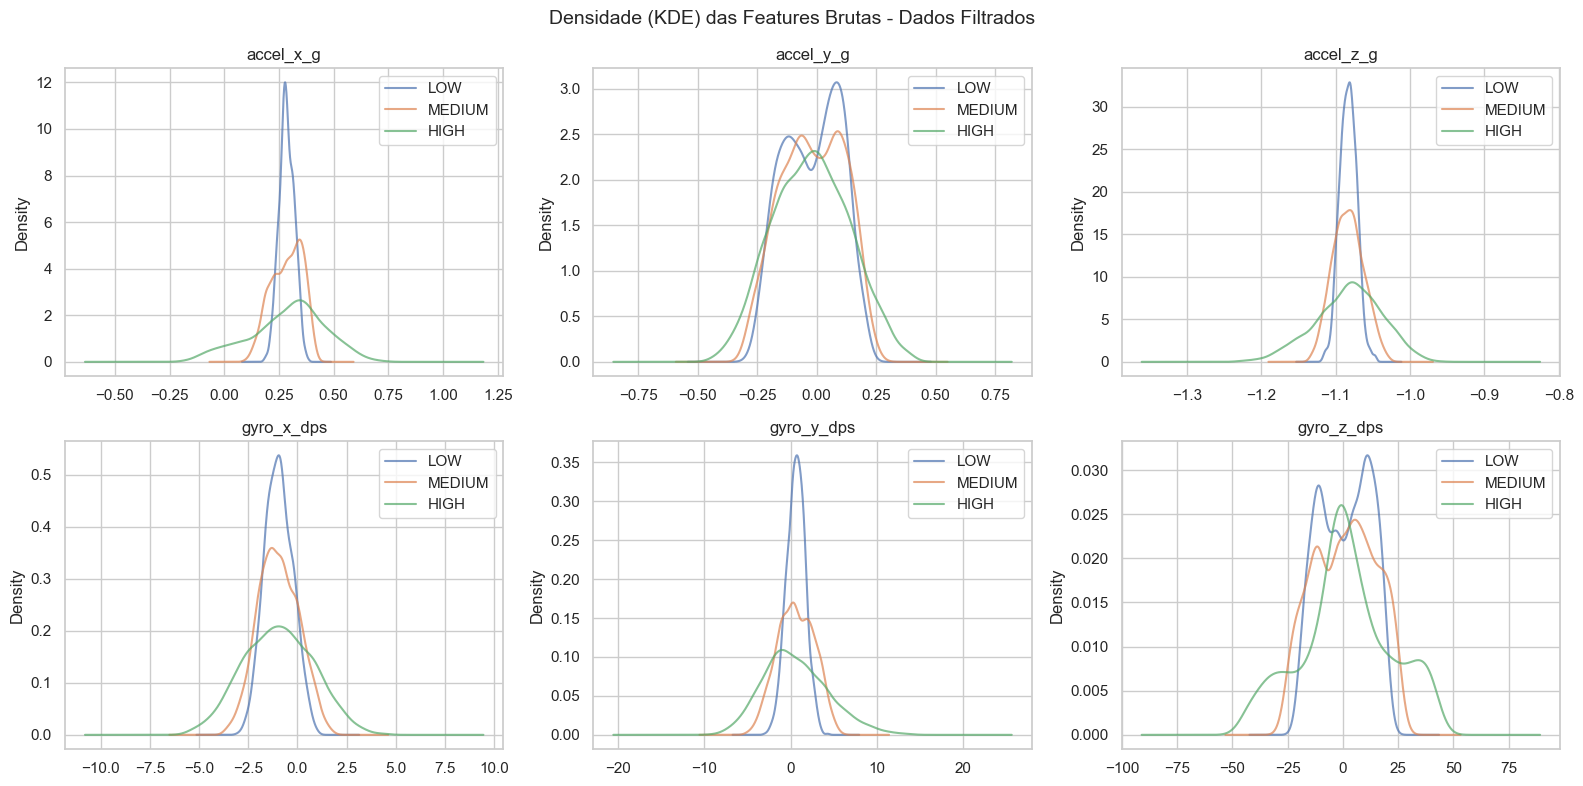

In [11]:
# =============================================================================
# Celula 11: Densidade das features brutas (KDE plots)
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes_flat = axes.flatten()

for i, axis in enumerate(SENSOR_AXES):
    for cls in ['LOW', 'MEDIUM', 'HIGH']:
        subset = df[df['fan_state'] == cls][axis]
        if len(subset) > 2:
            subset.plot.kde(ax=axes_flat[i], label=cls, alpha=0.7)
    axes_flat[i].set_title(axis)
    axes_flat[i].legend()

plt.suptitle('Densidade (KDE) das Features Brutas - Dados Filtrados', fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_FIGURES, '04_densidade_features_brutas.png'), dpi=150)
plt.show()

In [ ]:
# =============================================================================
# Celula 12: Engenharia de Features (janela deslizante)
#
# IMPORTANTE: ddof=0 no std (populacional) para alinhar com JavaScript
# 11 metricas por eixo x 6 eixos = 66 features por janela
# =============================================================================

def compute_features(window_values, axis_name):
    """Calcula 11 metricas estatisticas para uma janela de dados."""
    arr = np.asarray(window_values, dtype=np.float64)
    n = len(arr)
    if n == 0:
        return {}

    mean_val = np.mean(arr)
    # ddof=0: divisao por N (populacional) - alinhado com Stats.std() do JavaScript
    std_val = np.std(arr, ddof=0)
    skew_val = float(skew(arr, bias=True))
    kurt_val = float(kurtosis(arr, fisher=True, bias=True))
    rms_val = np.sqrt(np.mean(arr ** 2))
    peak_val = np.max(np.abs(arr))
    root_amplitude = (np.mean(np.sqrt(np.abs(arr)))) ** 2
    mean_abs = np.mean(np.abs(arr))
    crest_factor = peak_val / rms_val if rms_val > 1e-10 else 0.0
    shape_factor = rms_val / mean_abs if mean_abs > 1e-10 else 0.0
    impulse_factor = peak_val / mean_abs if mean_abs > 1e-10 else 0.0
    clearance_factor = peak_val / root_amplitude if root_amplitude > 1e-10 else 0.0

    return {
        f'{axis_name}_mean': mean_val,
        f'{axis_name}_std': std_val,
        f'{axis_name}_skew': skew_val,
        f'{axis_name}_kurtosis': kurt_val,
        f'{axis_name}_rms': rms_val,
        f'{axis_name}_peak': peak_val,
        f'{axis_name}_root_amplitude': root_amplitude,
        f'{axis_name}_crest_factor': crest_factor,
        f'{axis_name}_shape_factor': shape_factor,
        f'{axis_name}_impulse_factor': impulse_factor,
        f'{axis_name}_clearance_factor': clearance_factor,
    }


def extract_features_windowed(df_class, fan_state):
    """Extrai features por janela deslizante para uma classe, incluindo timestamp."""
    rows = []
    n = len(df_class)
    for start in range(0, n - WINDOW_SIZE + 1, STEP_SIZE):
        end = start + WINDOW_SIZE
        window_df = df_class.iloc[start:end]
        # Timestamp medio da janela (para rastreabilidade)
        ts_mean = window_df['timestamp_s'].mean()
        ts_start = window_df['timestamp_s'].iloc[0]
        ts_end = window_df['timestamp_s'].iloc[-1]
        feat = {
            'fan_state': fan_state,
            'window_start': start,
            'window_end': end,
            'timestamp_start': ts_start,
            'timestamp_end': ts_end,
            'timestamp_mean': ts_mean,
        }
        for axis in SENSOR_AXES:
            feat.update(compute_features(window_df[axis].values, axis))
        rows.append(feat)
    return rows


# Aplicar sobre os dados FILTRADOS
all_features = []
for cls in ['LOW', 'MEDIUM', 'HIGH']:
    df_cls = df[df['fan_state'] == cls].reset_index(drop=True)
    features = extract_features_windowed(df_cls, cls)
    all_features.extend(features)
    print(f'{cls}: {len(features)} janelas de {len(df_cls)} amostras')

df_features = pd.DataFrame(all_features)

# Colunas de features (numericas, excluindo metadados)
meta_cols = ['fan_state', 'window_start', 'window_end', 'timestamp_start', 'timestamp_end', 'timestamp_mean']
feature_cols = [c for c in df_features.columns if c not in meta_cols]

print(f'\nTotal de janelas: {len(df_features)}')
print(f'Features por janela: {len(feature_cols)}')
print(f'Distribuicao: {df_features["fan_state"].value_counts().to_dict()}')

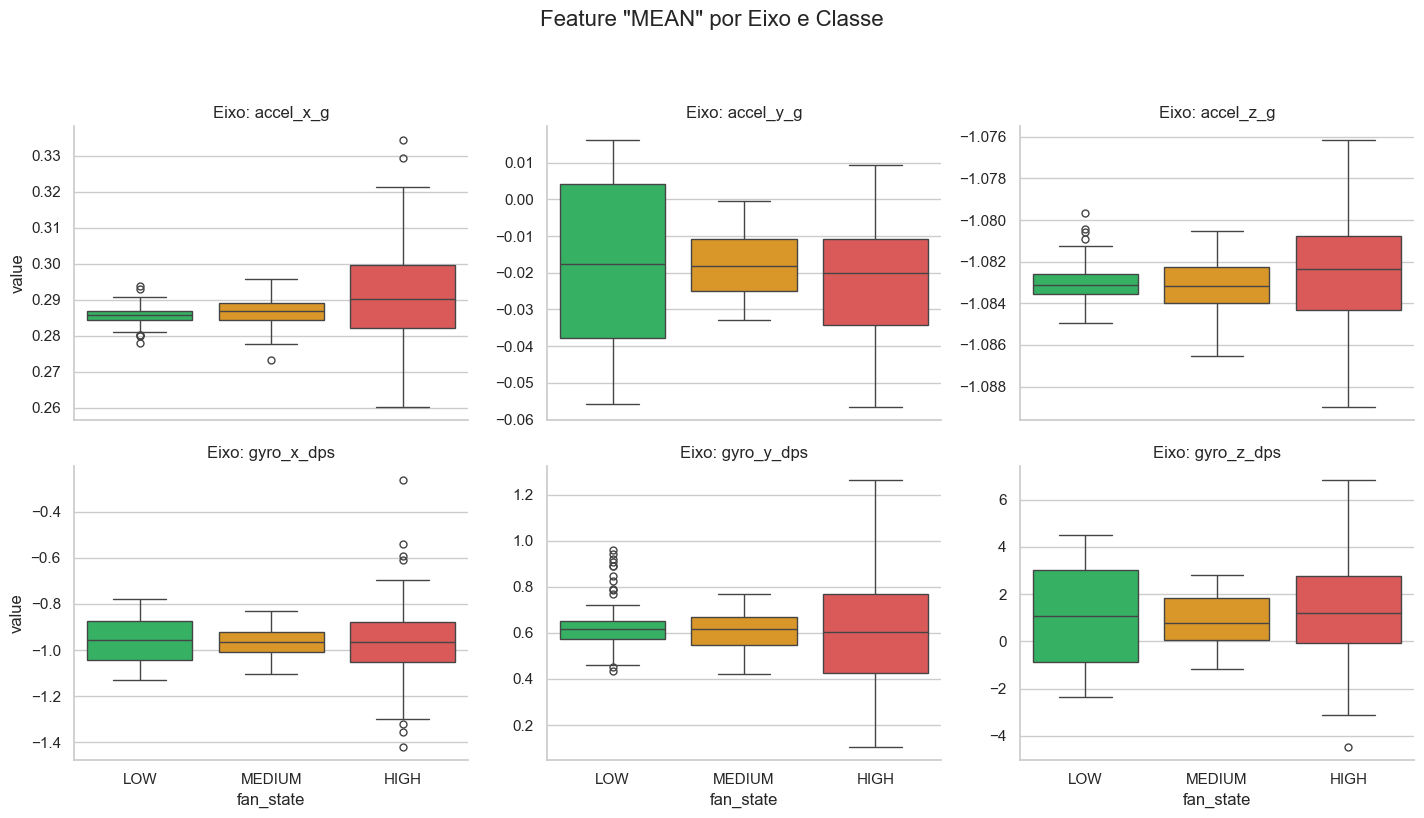

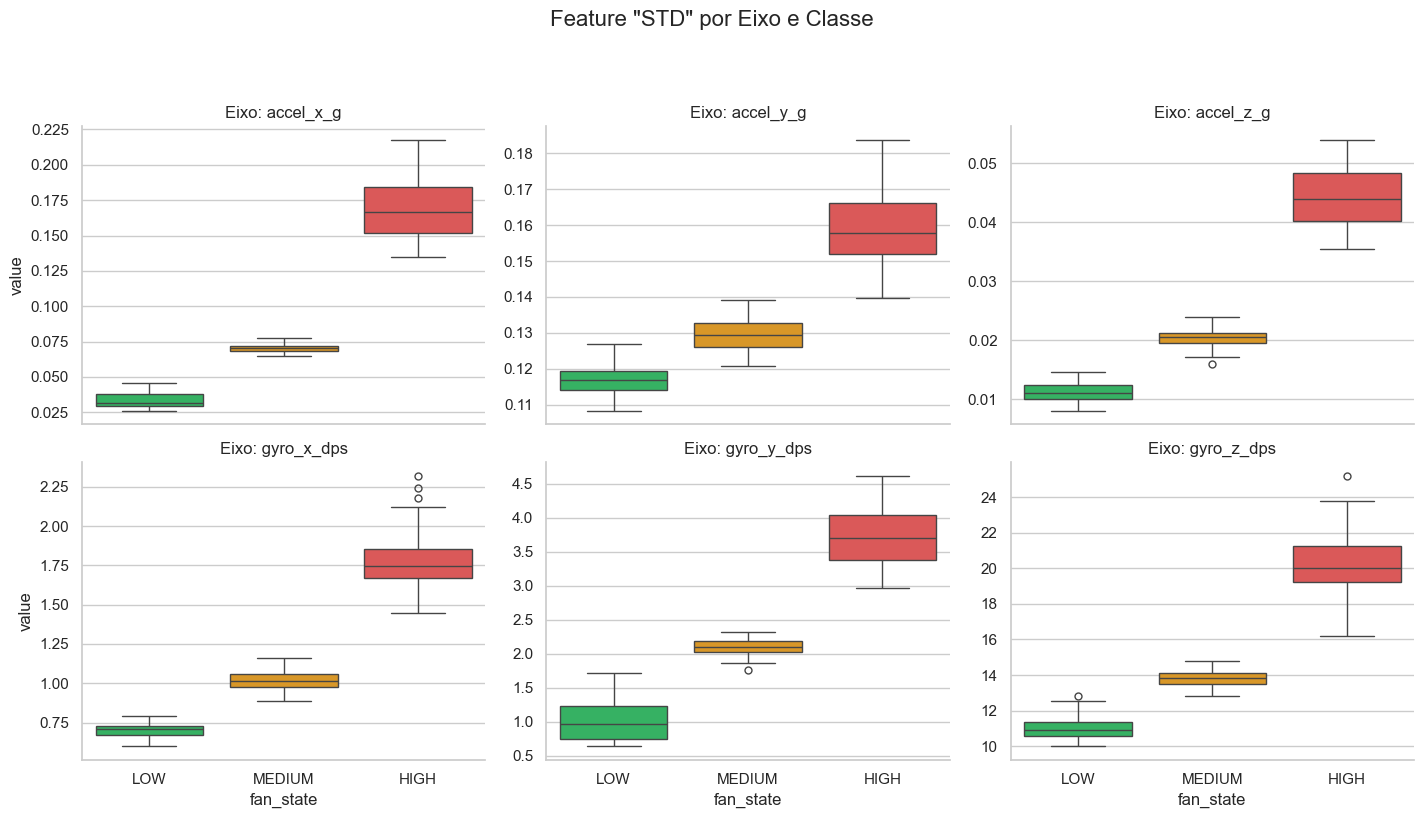

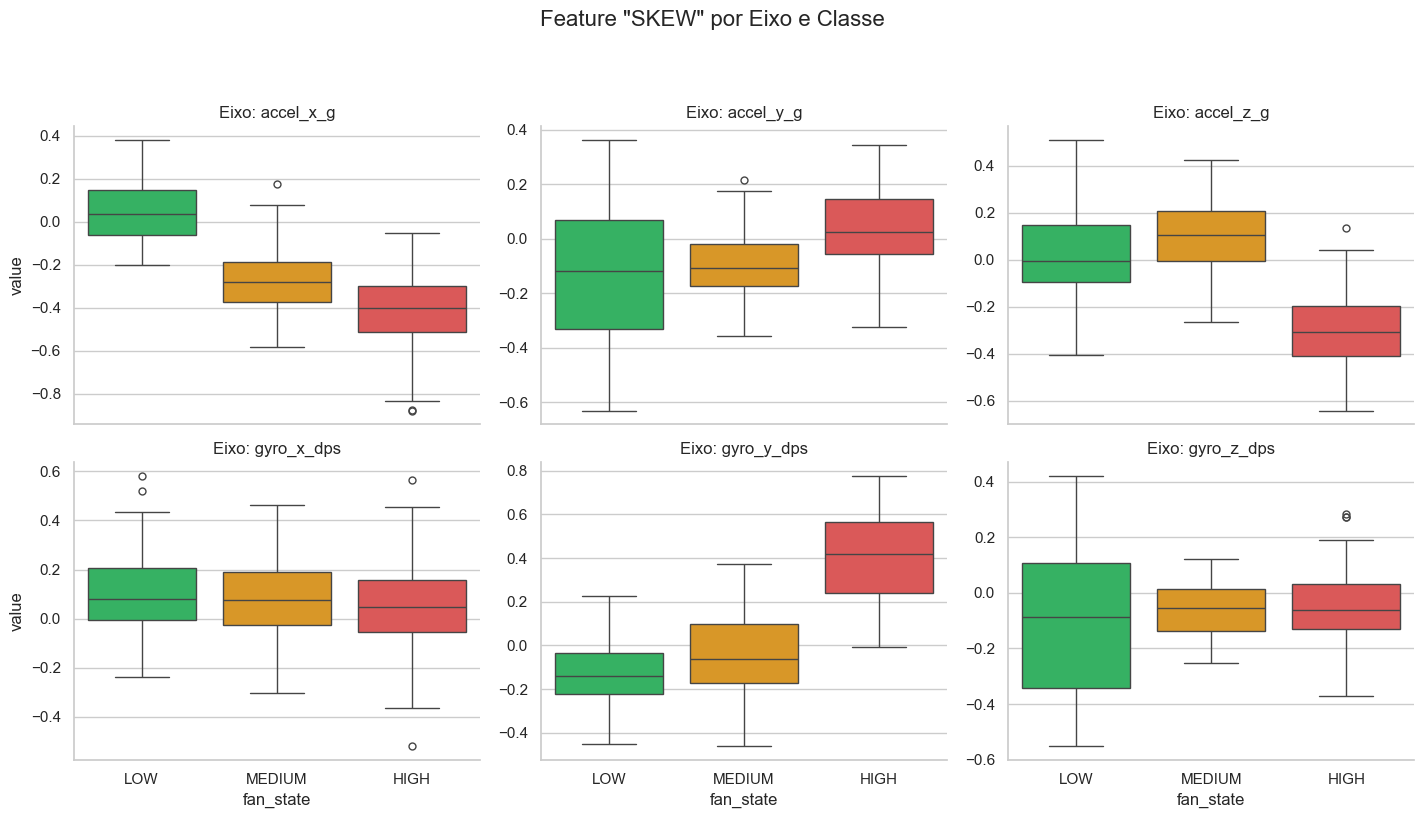

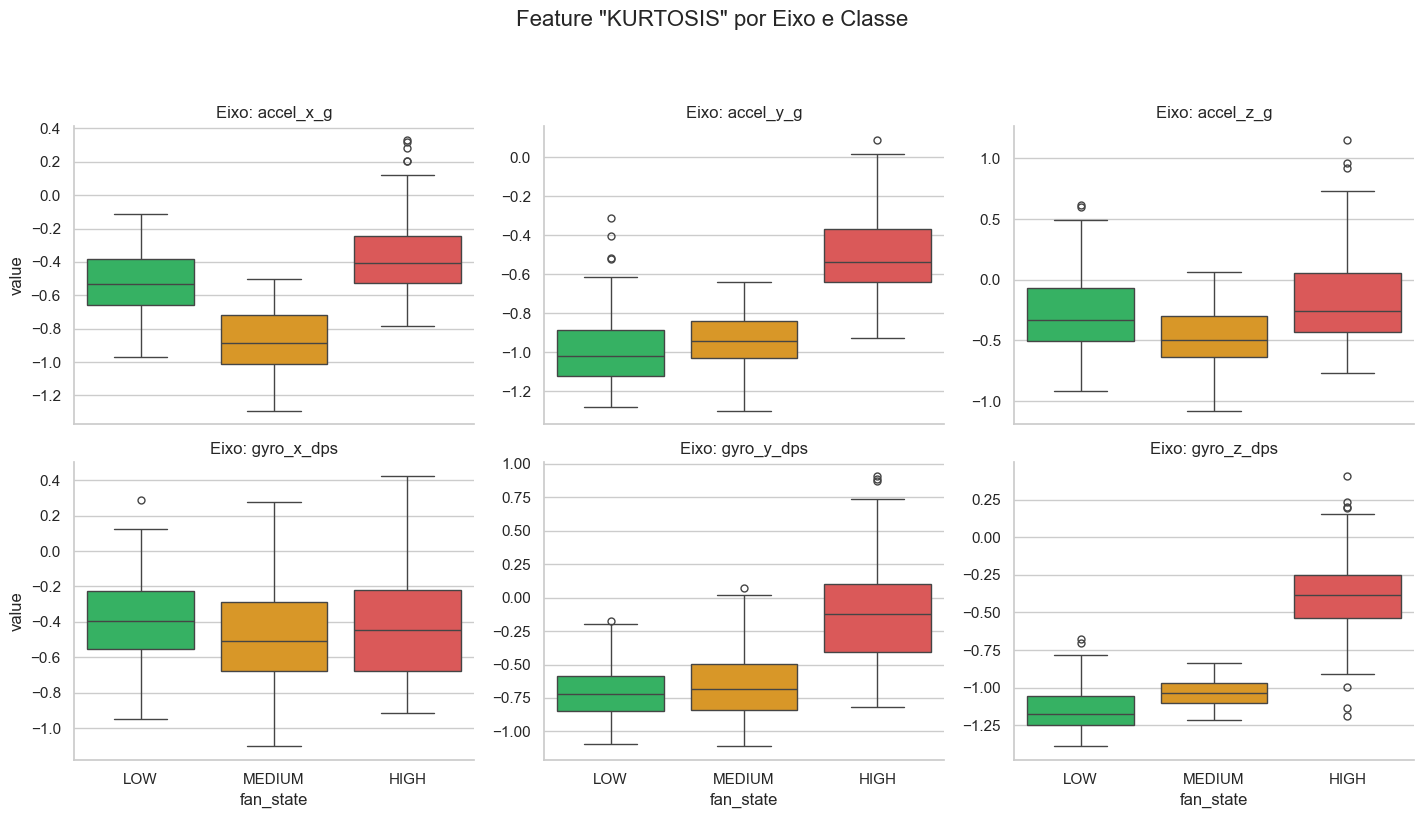

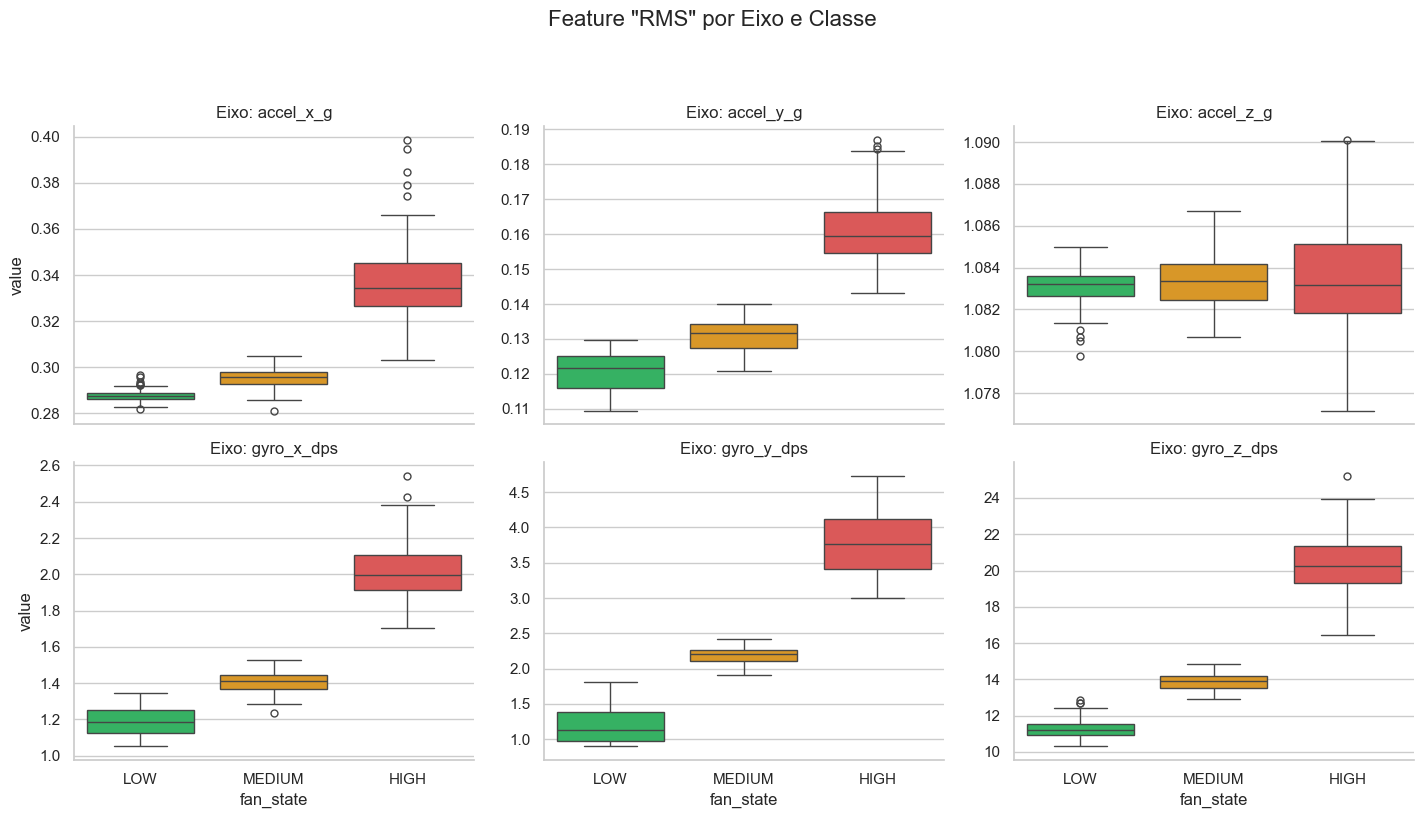

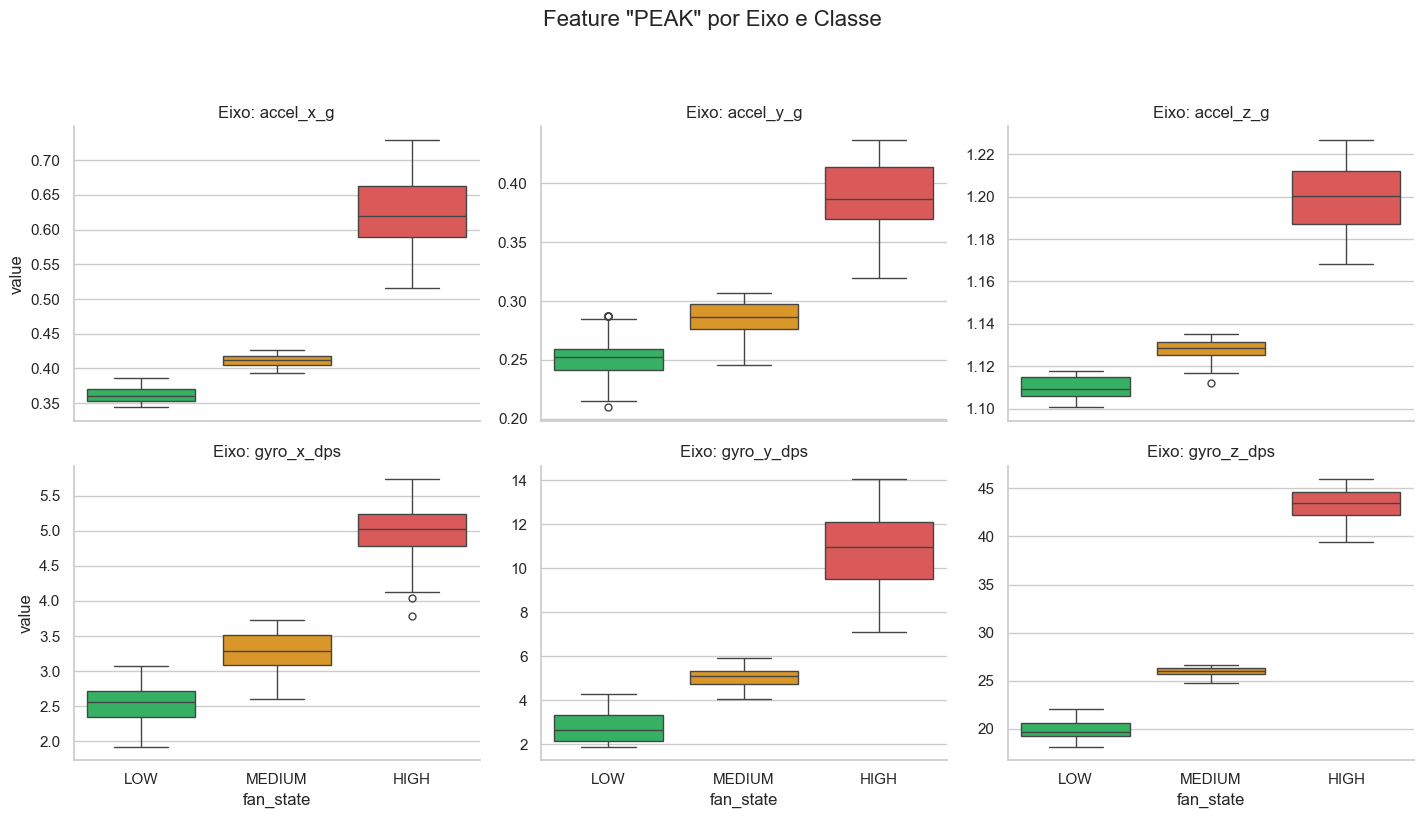

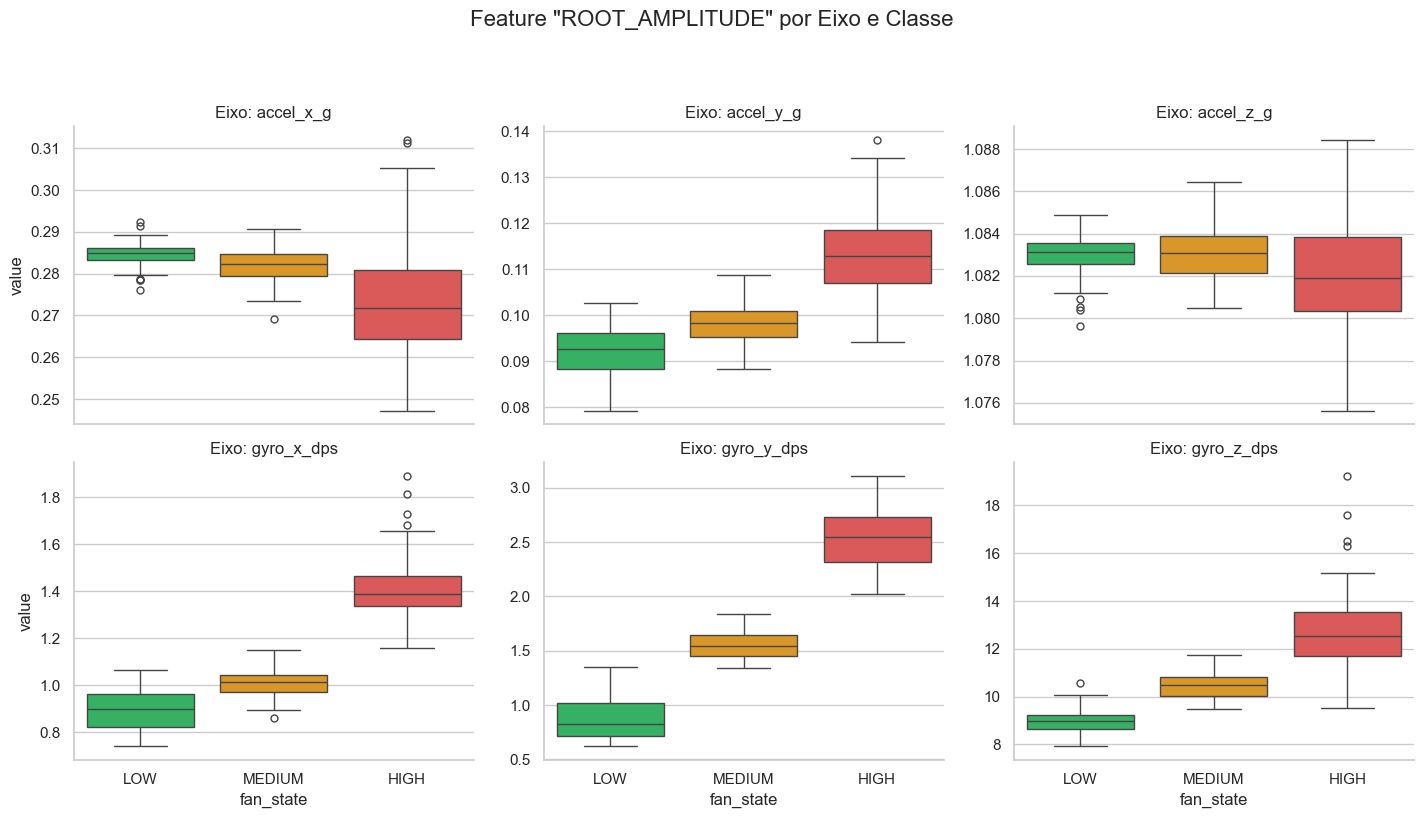

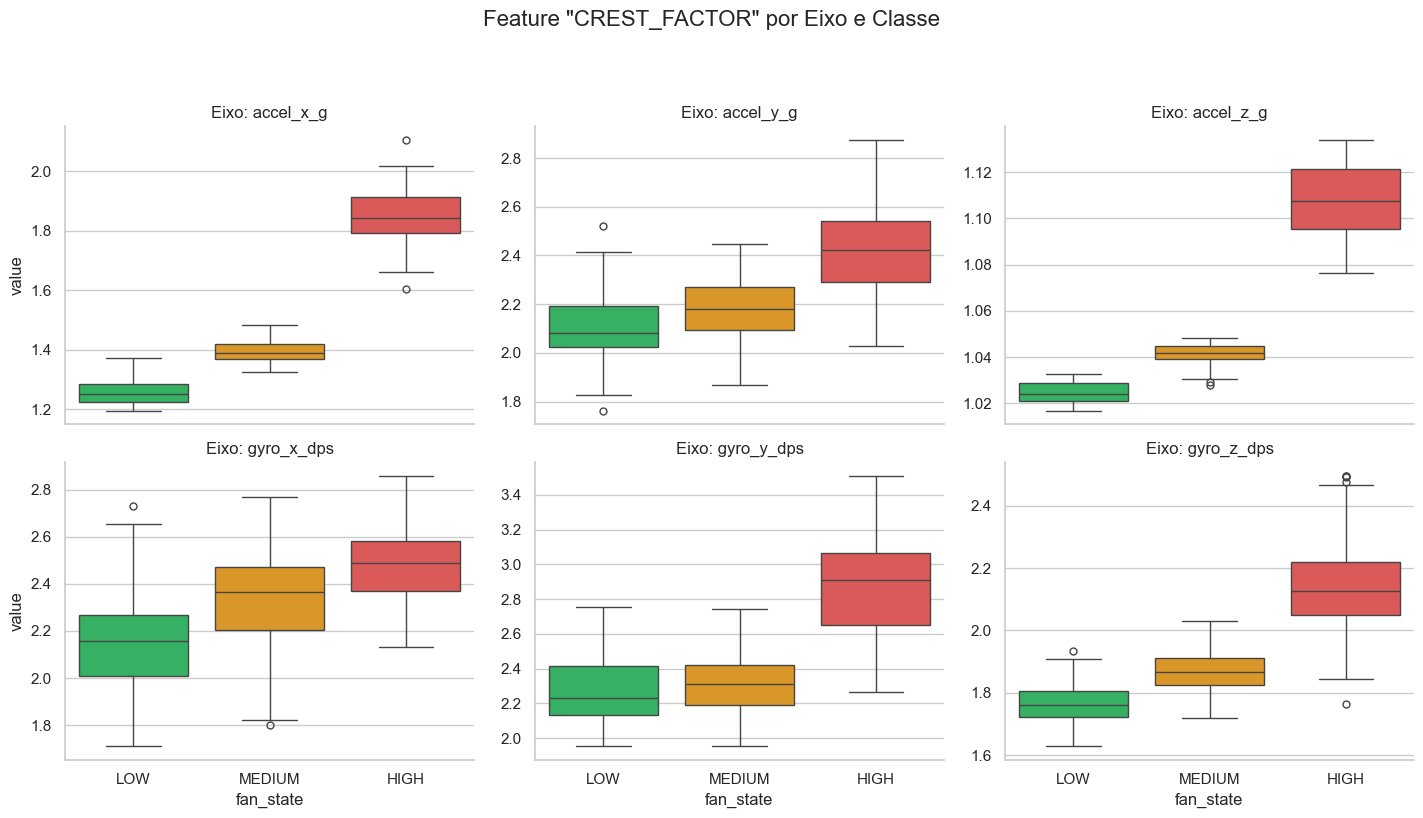

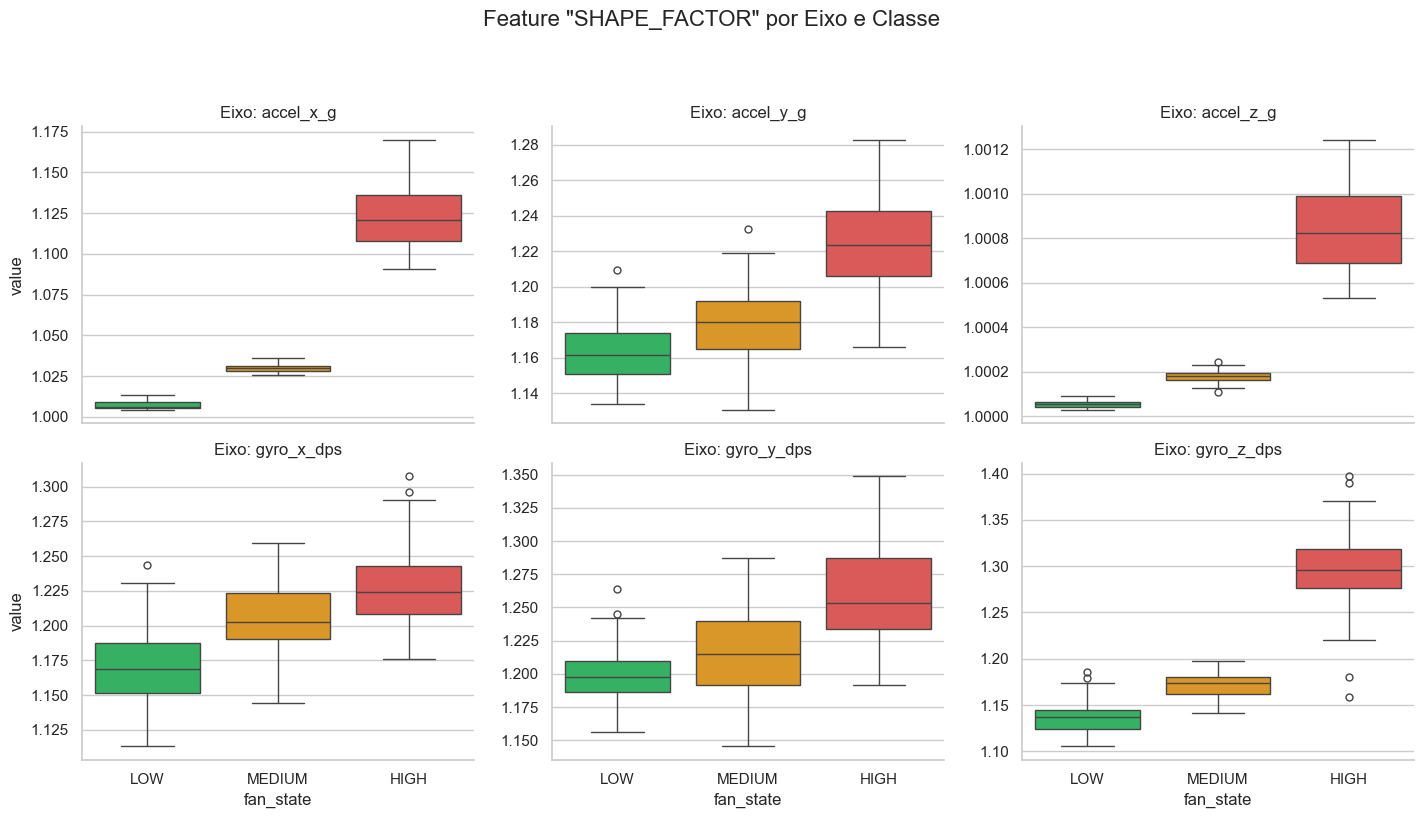

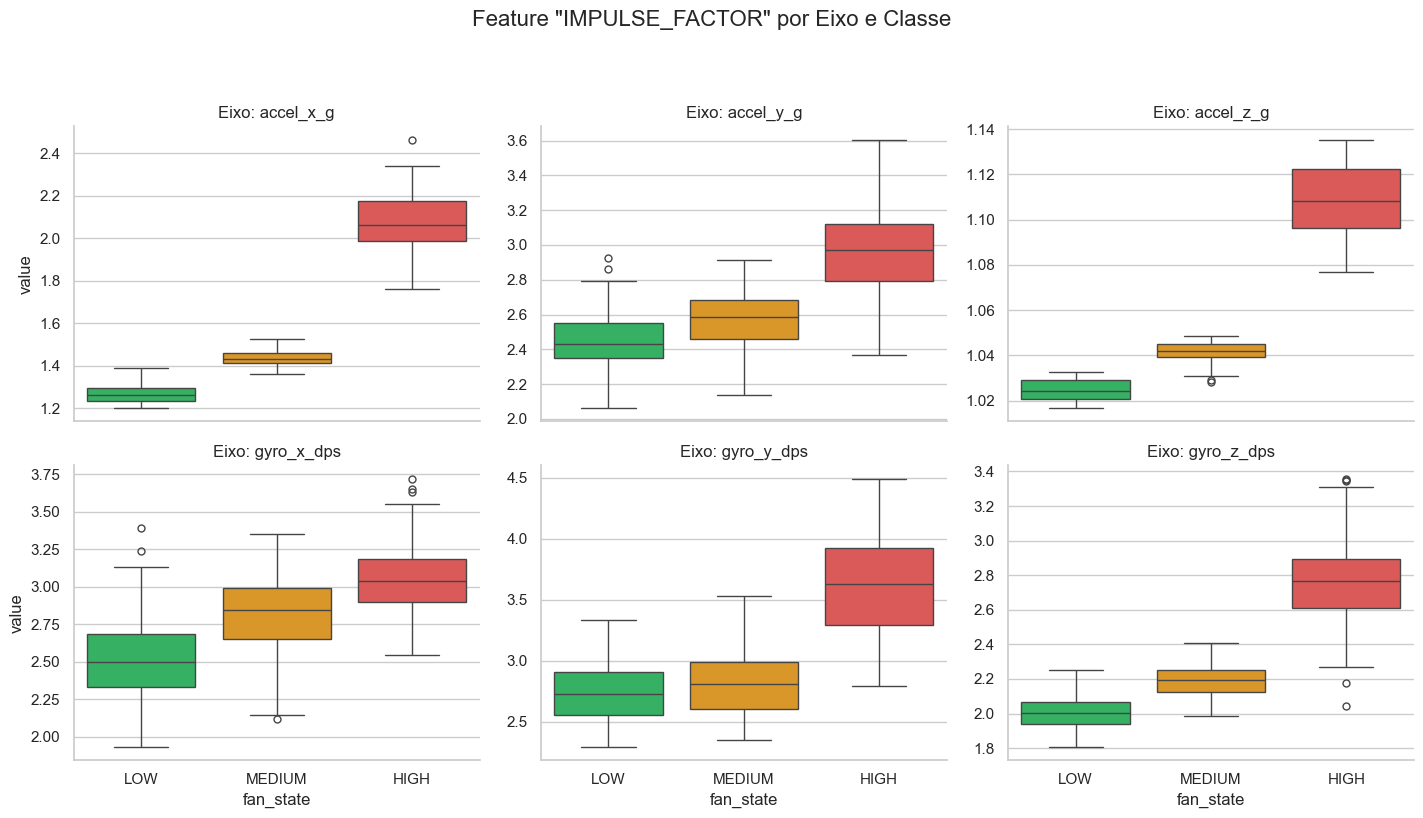

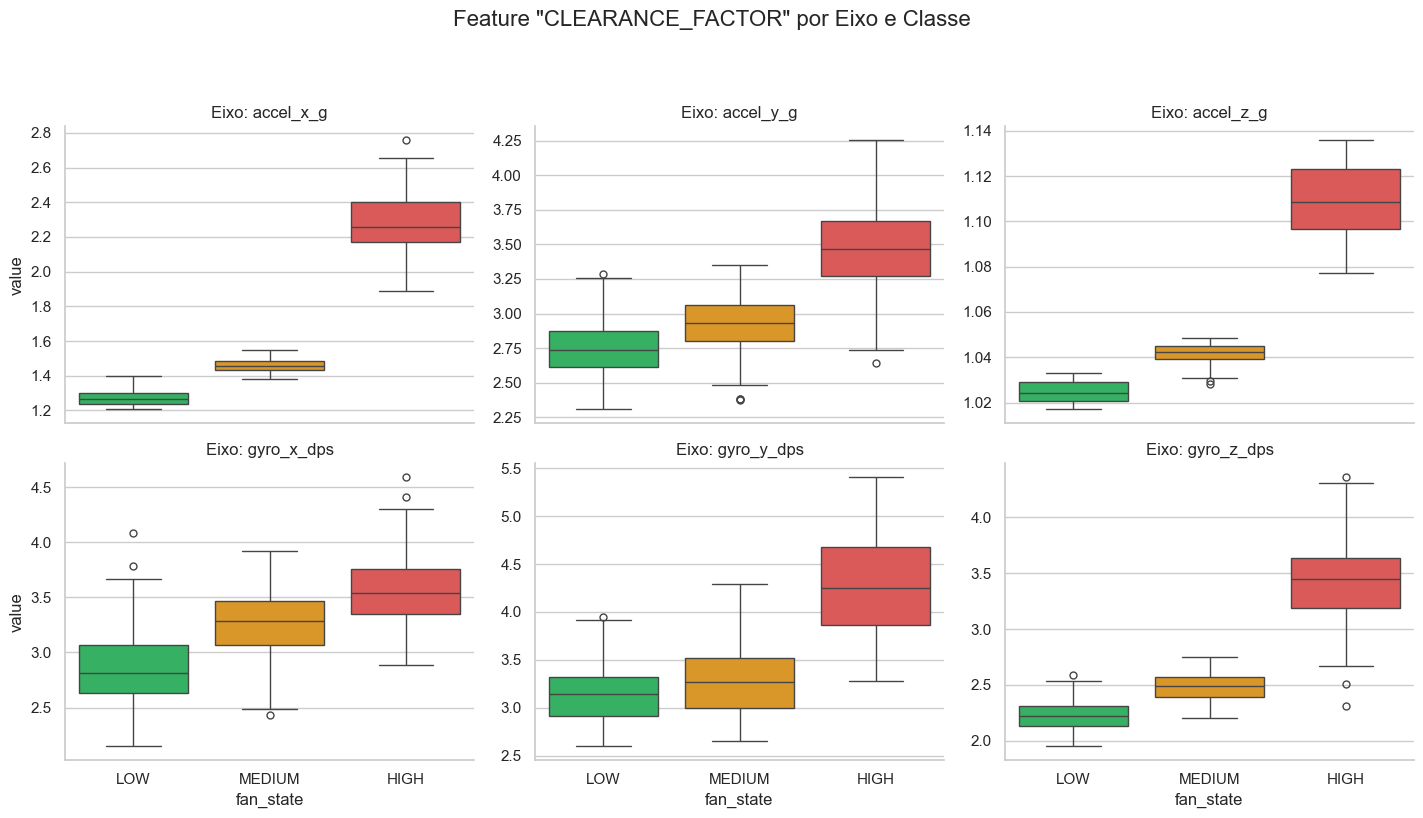

In [13]:
# =============================================================================
# Celula 13: Analise visual das features (boxplot por classe)
# =============================================================================
feature_types = ['mean', 'std', 'skew', 'kurtosis', 'rms', 'peak',
                 'root_amplitude', 'crest_factor', 'shape_factor',
                 'impulse_factor', 'clearance_factor']

for feature_type in feature_types:
    cols_to_plot = [f'{ax}_{feature_type}' for ax in SENSOR_AXES]
    cols_to_plot = [c for c in cols_to_plot if c in feature_cols]
    if not cols_to_plot:
        continue

    df_melted = df_features.melt(
        id_vars=['fan_state'], value_vars=cols_to_plot,
        var_name='feature_axis', value_name='value'
    )
    df_melted['axis'] = df_melted['feature_axis'].str.replace(f'_{feature_type}', '', regex=False)

    g = sns.catplot(
        data=df_melted, x='fan_state', y='value', col='axis',
        kind='box', col_wrap=3, height=4, aspect=1.2,
        order=['LOW', 'MEDIUM', 'HIGH'],
        palette={'LOW': '#22c55e', 'MEDIUM': '#f59e0b', 'HIGH': '#ef4444'},
        sharey=False,
    )
    g.figure.suptitle(f'Feature "{feature_type.upper()}" por Eixo e Classe', fontsize=16, y=1.02)
    g.set_titles('Eixo: {col_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    g.figure.savefig(os.path.join(OUTPUT_FIGURES, f'05_catplot_feature_{feature_type}.png'), dpi=150)
    plt.show()

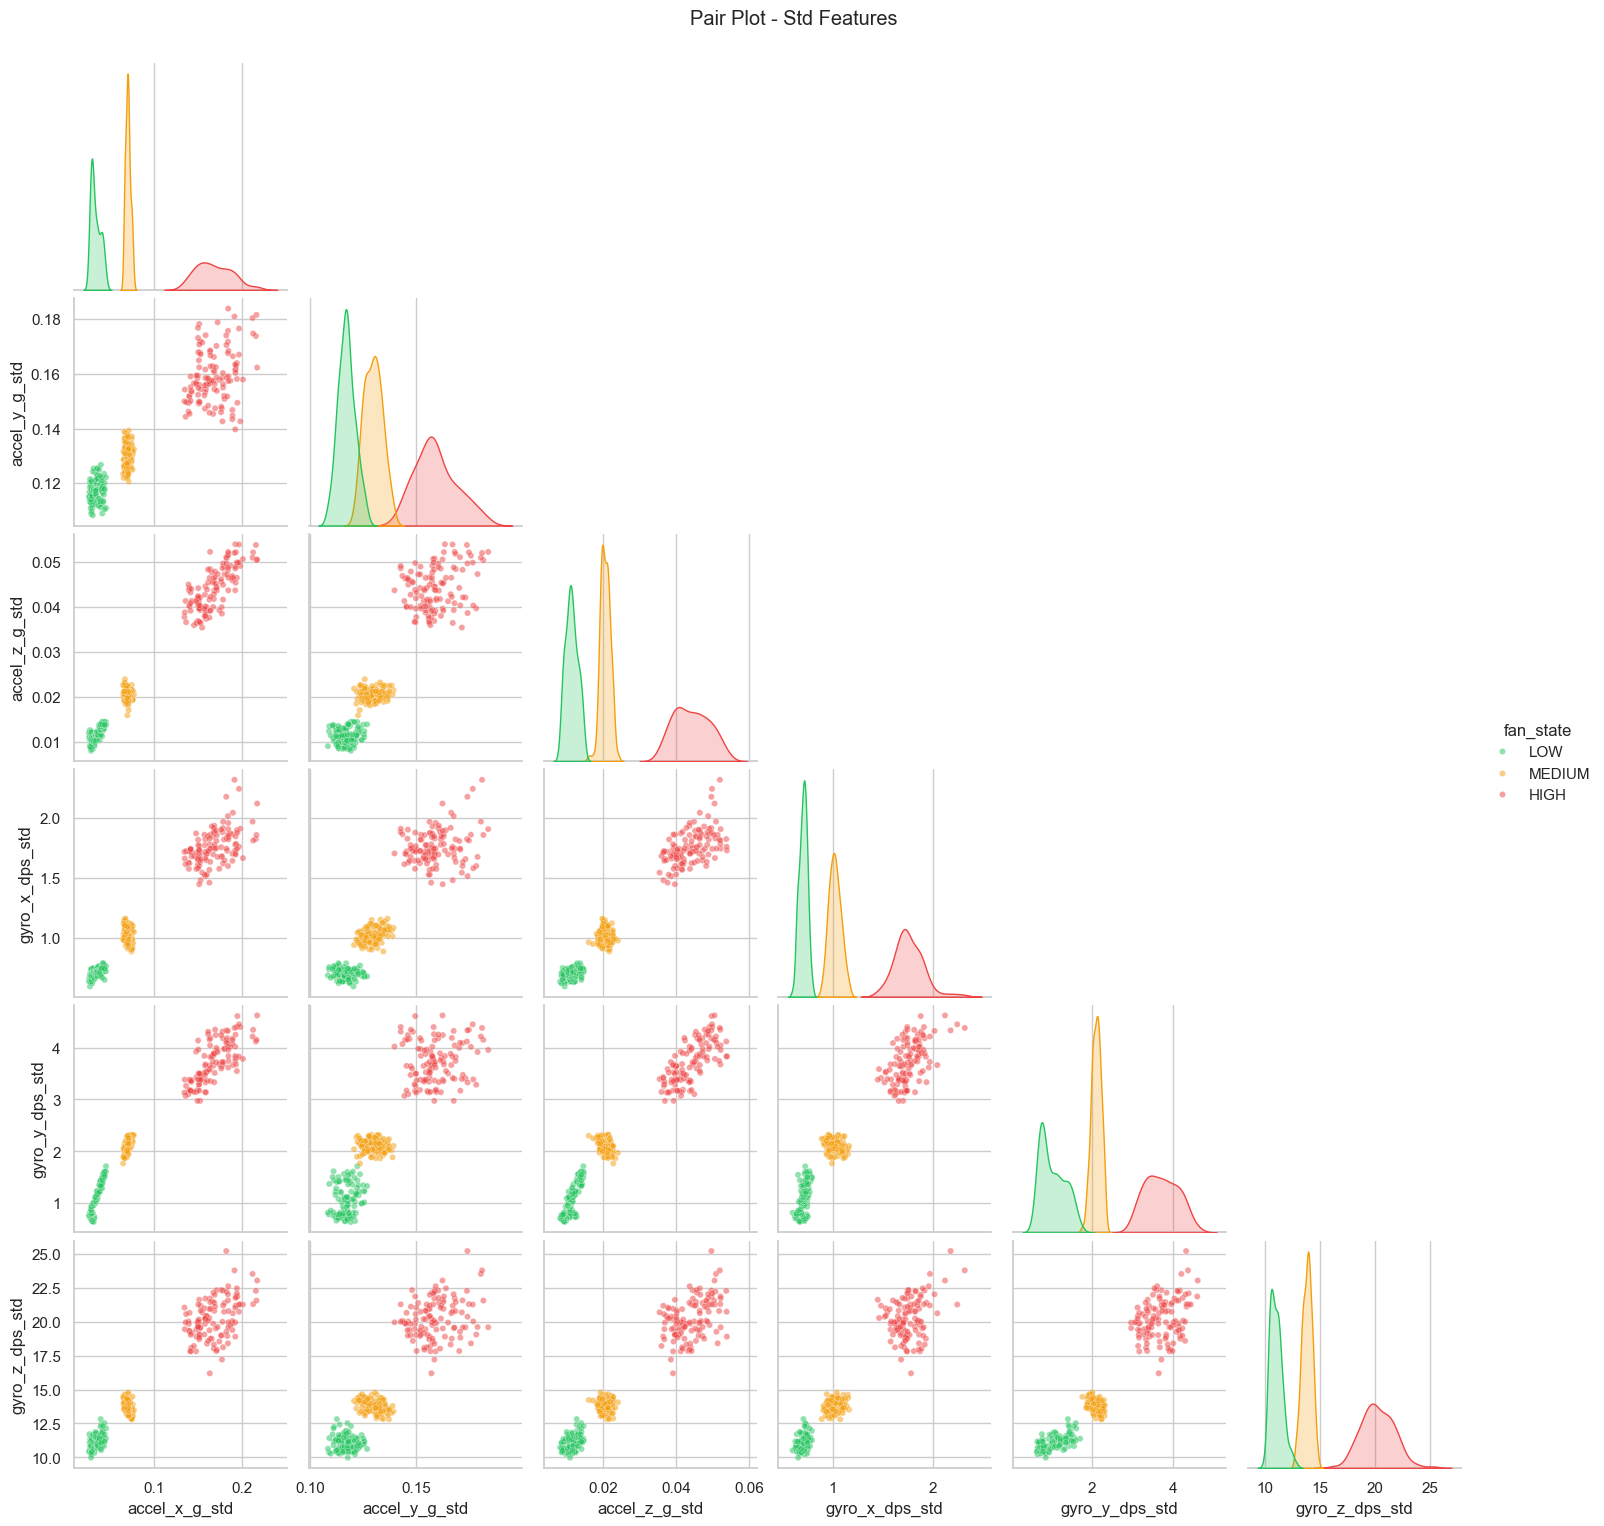

In [14]:
# =============================================================================
# Celula 14: Pair plot das features std (mais discriminativas)
# =============================================================================
pairplot_features = [f'{ax}_std' for ax in SENSOR_AXES]
pairplot_features = [f for f in pairplot_features if f in feature_cols]

if len(pairplot_features) > 1:
    g = sns.pairplot(
        df_features[pairplot_features + ['fan_state']],
        hue='fan_state',
        palette={'LOW': '#22c55e', 'MEDIUM': '#f59e0b', 'HIGH': '#ef4444'},
        hue_order=['LOW', 'MEDIUM', 'HIGH'],
        diag_kind='kde',
        plot_kws={'alpha': 0.5, 's': 20},
        corner=True,
    )
    g.figure.suptitle('Pair Plot - Std Features', y=1.02)
    g.figure.savefig(os.path.join(OUTPUT_FIGURES, '06_pairplot_std_features.png'), dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
# =============================================================================
# Celula 14b: Violin plots das features mais discriminativas
# =============================================================================
top_features_for_violin = [f'{ax}_std' for ax in SENSOR_AXES] + [f'{ax}_peak' for ax in SENSOR_AXES[:3]]

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes_flat = axes.flatten()

for i, feat in enumerate(top_features_for_violin):
    if i >= len(axes_flat) or feat not in feature_cols:
        continue
    sns.violinplot(
        data=df_features, x='fan_state', y=feat, ax=axes_flat[i],
        order=['LOW', 'MEDIUM', 'HIGH'],
        palette={'LOW': '#22c55e', 'MEDIUM': '#f59e0b', 'HIGH': '#ef4444'},
        inner='quartile', cut=0,
    )
    axes_flat[i].set_title(feat, fontsize=11)
    axes_flat[i].set_xlabel('')

plt.suptitle('Violin Plots - Distribuicao das Features por Classe', fontsize=16, y=1.01)
plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_FIGURES, '08_violin_plots.png'), dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# =============================================================================
# Celula 14c: t-SNE e PCA - Visualizacao de separabilidade das classes
# =============================================================================
from sklearn.preprocessing import StandardScaler

X_viz = df_features[feature_cols].values
y_viz = df_features['fan_state'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_viz)

color_map = {'LOW': '#22c55e', 'MEDIUM': '#f59e0b', 'HIGH': '#ef4444'}

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
for cls in ['LOW', 'MEDIUM', 'HIGH']:
    mask = y_viz == cls
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], c=color_map[cls], label=cls, alpha=0.6, s=30)
axes[0].set_title(f'PCA 2D (var explicada: {pca.explained_variance_ratio_.sum()*100:.1f}%)', fontsize=13)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].legend()

# t-SNE 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
for cls in ['LOW', 'MEDIUM', 'HIGH']:
    mask = y_viz == cls
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=color_map[cls], label=cls, alpha=0.6, s=30)
axes[1].set_title('t-SNE 2D', fontsize=13)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].legend()

plt.suptitle('Separabilidade das Classes (66 features)', fontsize=16, y=1.02)
plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_FIGURES, '09_pca_tsne.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f'Variancia explicada PCA: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, PC2={pca.explained_variance_ratio_[1]*100:.1f}%')

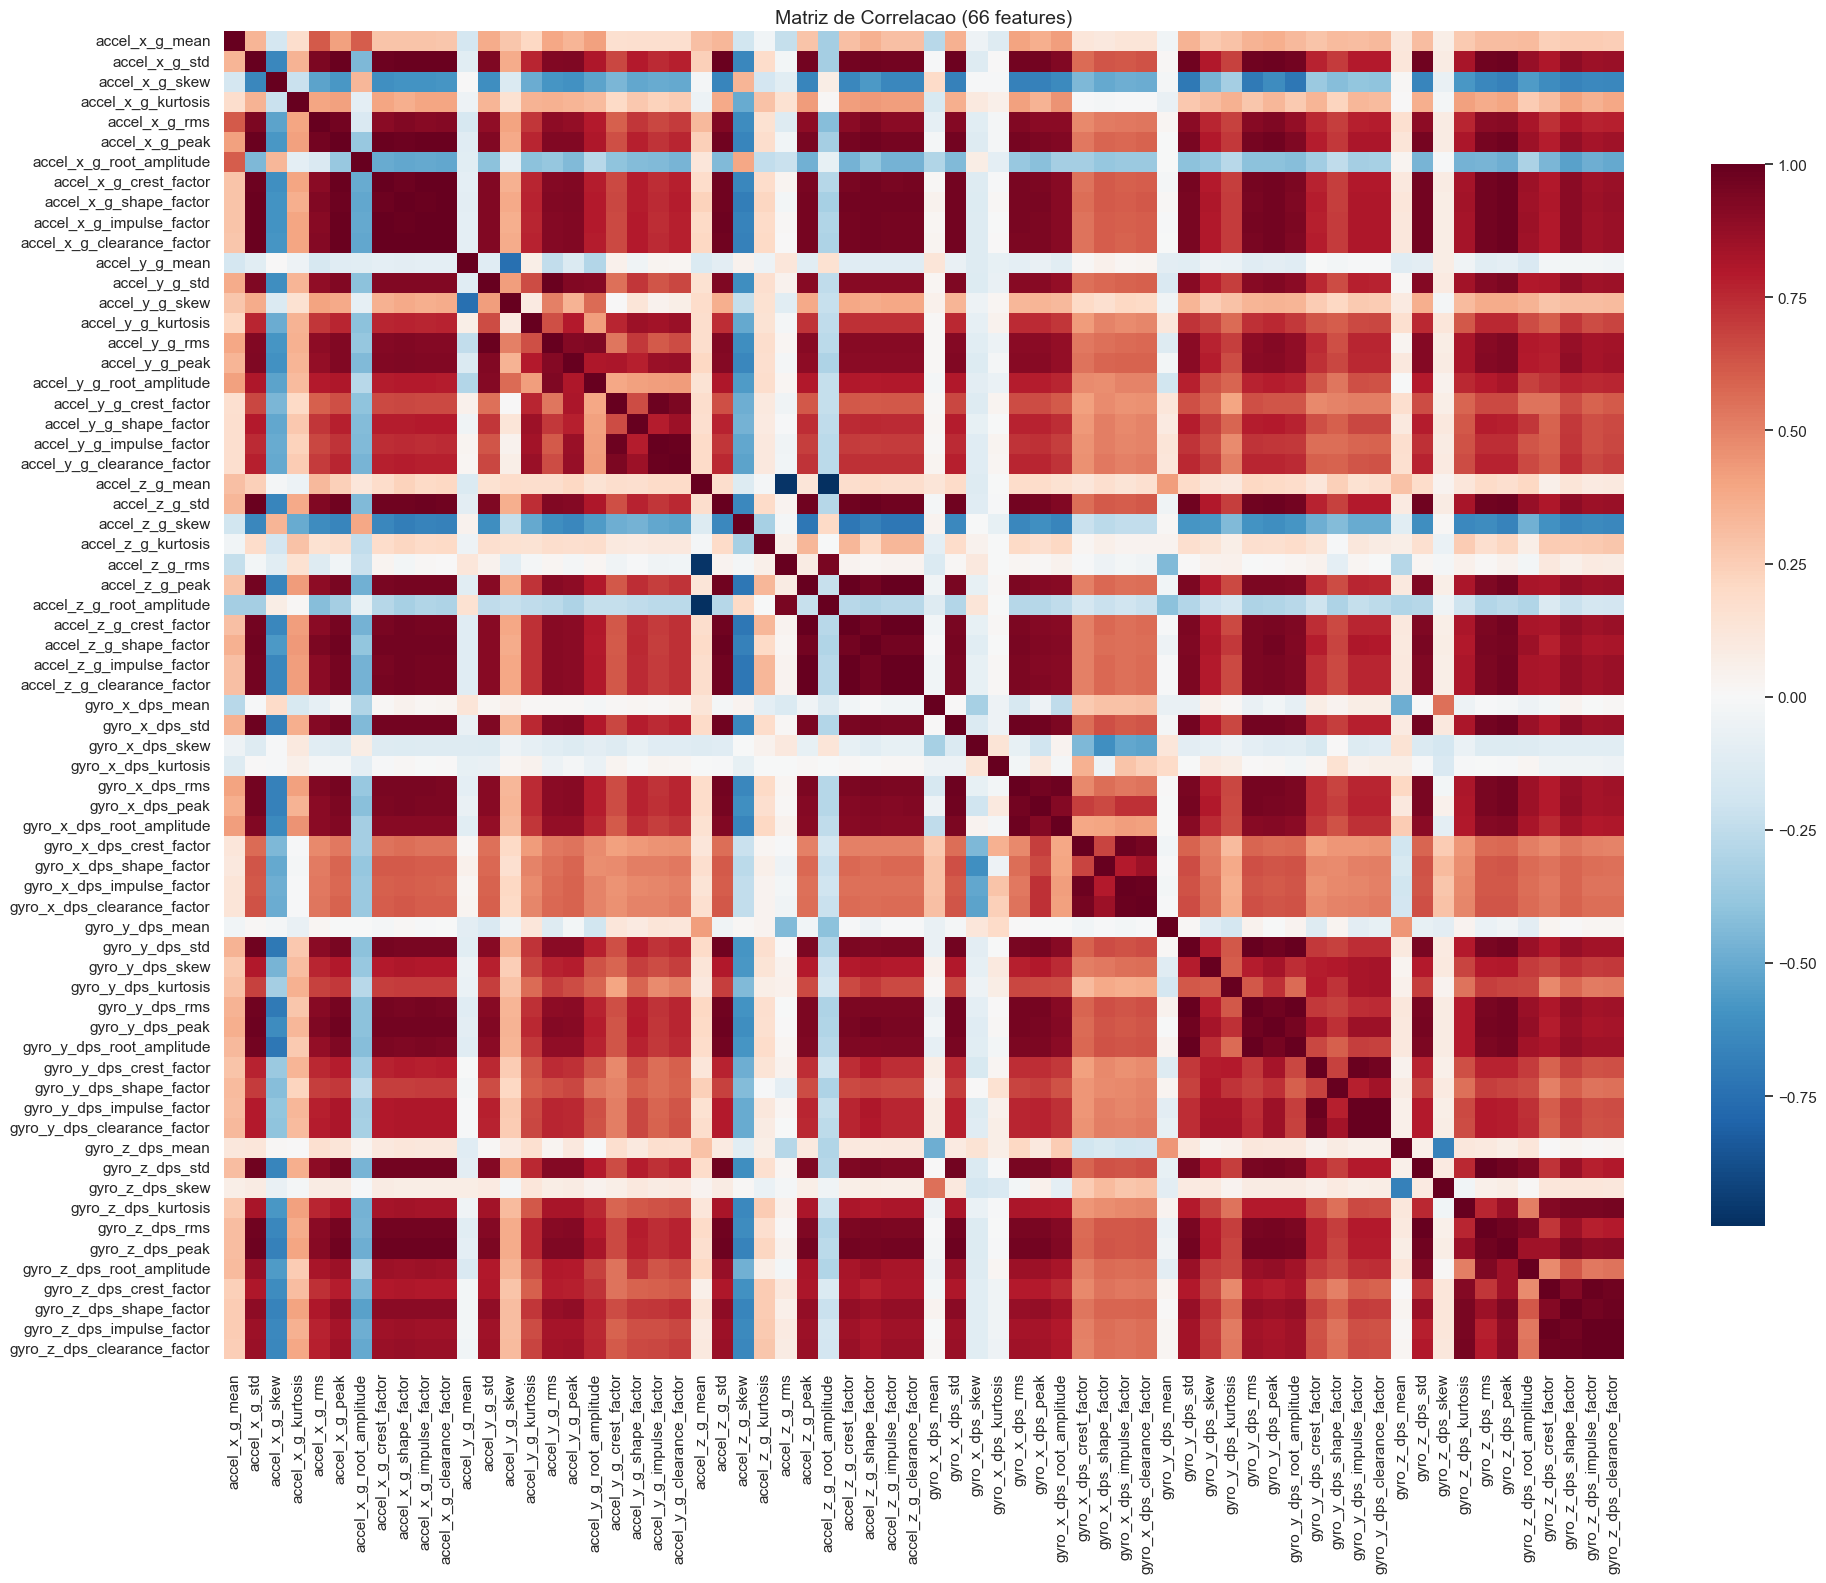

In [15]:
# =============================================================================
# Celula 15: Matriz de correlacao
# =============================================================================
corr_matrix = df_features[feature_cols].corr()

fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, ax=ax,
            xticklabels=True, yticklabels=True,
            cbar_kws={'shrink': 0.8})
ax.set_title(f'Matriz de Correlacao ({len(feature_cols)} features)', fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_FIGURES, '07_heatmap_correlacao.png'), dpi=150)
plt.show()

In [16]:
# =============================================================================
# Celula 16: Selecao de features - ANOVA F-test (3 classes) + filtro de correlacao
# =============================================================================

# 1. ANOVA F-test para 3 classes
anova_results = []
for feat in feature_cols:
    groups = [df_features[df_features['fan_state'] == cls][feat].dropna().values
              for cls in ['LOW', 'MEDIUM', 'HIGH']]
    if all(len(g) > 1 for g in groups):
        f_stat, p_val = scipy_stats.f_oneway(*groups)
        anova_results.append({
            'feature': feat,
            'f_statistic': f_stat,
            'p_value': p_val,
        })

df_anova = pd.DataFrame(anova_results).sort_values('f_statistic', ascending=False)

# Filtrar por significancia
df_significant = df_anova[df_anova['p_value'] < ANOVA_ALPHA].copy()
print(f'Features significativas (p < {ANOVA_ALPHA}): {len(df_significant)} de {len(df_anova)}')

# 2. Filtro de correlacao: remover features altamente correlacionadas
significant_features = df_significant['feature'].tolist()
corr_subset = df_features[significant_features].corr().abs()

upper = corr_subset.where(np.triu(np.ones(corr_subset.shape), k=1).astype(bool))

to_remove = set()
for col in upper.columns:
    correlated = upper.index[upper[col] > CORRELATION_THRESHOLD].tolist()
    for corr_feat in correlated:
        f_col = df_significant[df_significant['feature'] == col]['f_statistic'].values[0]
        f_corr = df_significant[df_significant['feature'] == corr_feat]['f_statistic'].values[0]
        if f_corr < f_col:
            to_remove.add(corr_feat)
        else:
            to_remove.add(col)

selected_features = [f for f in significant_features if f not in to_remove]

print(f'Removidas por correlacao > {CORRELATION_THRESHOLD}: {len(to_remove)}')
print(f'Features selecionadas FINAL: {len(selected_features)}')
print()
for i, f in enumerate(selected_features, 1):
    row = df_significant[df_significant['feature'] == f].iloc[0]
    print(f'  {i:2d}. {f:40s} F={row["f_statistic"]:10.2f}  p={row["p_value"]:.2e}')

Features significativas (p < 0.05): 59 de 66
Removidas por correlacao > 0.85: 45
Features selecionadas FINAL: 14

   1. gyro_z_dps_peak                          F=  14816.05  p=0.00e+00
   2. gyro_y_dps_skew                          F=    331.32  p=2.95e-82
   3. accel_x_g_skew                           F=    315.96  p=7.08e-80
   4. accel_z_g_skew                           F=    242.10  p=2.72e-67
   5. accel_x_g_kurtosis                       F=    194.88  p=4.96e-58
   6. gyro_x_dps_shape_factor                  F=    155.82  p=1.92e-49
   7. gyro_y_dps_kurtosis                      F=    154.21  p=4.56e-49
   8. gyro_y_dps_shape_factor                  F=    148.81  p=8.52e-48
   9. accel_x_g_root_amplitude                 F=     62.58  p=4.82e-24
  10. accel_z_g_kurtosis                       F=     29.50  p=1.38e-12
  11. accel_y_g_skew                           F=     28.62  p=2.92e-12
  12. accel_x_g_mean                           F=     18.16  p=3.06e-08
  13. accel_z_g_root_a

In [ ]:
# =============================================================================
# Celula 16b: Validacao robusta - Kruskal-Wallis + Mutual Information
#
# Kruskal-Wallis: teste nao-parametrico (nao assume normalidade)
# Mutual Information: captura relacoes nao-lineares entre feature e classe
# =============================================================================

# --- 1. Kruskal-Wallis (nao-parametrico) ---
kw_results = []
for feat in feature_cols:
    groups = [df_features[df_features['fan_state'] == cls][feat].dropna().values
              for cls in ['LOW', 'MEDIUM', 'HIGH']]
    if all(len(g) > 1 for g in groups):
        h_stat, p_val = kruskal(*groups)
        kw_results.append({'feature': feat, 'h_statistic': h_stat, 'p_value': p_val})

df_kw = pd.DataFrame(kw_results).sort_values('h_statistic', ascending=False)
kw_significant = df_kw[df_kw['p_value'] < ANOVA_ALPHA]['feature'].tolist()

print(f'=== Kruskal-Wallis ===')
print(f'Features significativas (p < {ANOVA_ALPHA}): {len(kw_significant)} de {len(df_kw)}')

# --- 2. Mutual Information ---
le = LabelEncoder()
y_encoded = le.fit_transform(df_features['fan_state'])
X_features = df_features[feature_cols]

mi_scores = mutual_info_classif(X_features, y_encoded, random_state=42)
df_mi = pd.DataFrame({'feature': feature_cols, 'mi_score': mi_scores}).sort_values('mi_score', ascending=False)

print(f'\n=== Mutual Information ===')
print(f'Top 15 features por MI:')
for _, row in df_mi.head(15).iterrows():
    print(f'  {row["feature"]:40s} MI={row["mi_score"]:.4f}')

# --- 3. Comparacao de rankings ---
df_ranking = pd.DataFrame({'feature': feature_cols})
anova_rank = {row['feature']: i+1 for i, (_, row) in enumerate(df_anova.iterrows())}
df_ranking['anova_rank'] = df_ranking['feature'].map(anova_rank)
kw_rank = {row['feature']: i+1 for i, (_, row) in enumerate(df_kw.iterrows())}
df_ranking['kw_rank'] = df_ranking['feature'].map(kw_rank)
mi_rank = {row['feature']: i+1 for i, (_, row) in enumerate(df_mi.iterrows())}
df_ranking['mi_rank'] = df_ranking['feature'].map(mi_rank)
df_ranking['avg_rank'] = df_ranking[['anova_rank', 'kw_rank', 'mi_rank']].mean(axis=1)
df_ranking = df_ranking.sort_values('avg_rank')

print(f'\n=== Ranking Consensual (media dos 3 metodos) ===')
print(f'Top 20 features:')
for _, row in df_ranking.head(20).iterrows():
    in_selected = '*' if row['feature'] in selected_features else ' '
    print(f'  {in_selected} {row["feature"]:40s} ANOVA={row["anova_rank"]:3.0f}  KW={row["kw_rank"]:3.0f}  MI={row["mi_rank"]:3.0f}  AVG={row["avg_rank"]:.1f}')
print(f'\n  * = presente nas 14 features selecionadas pelo ANOVA')

# Verificar concordancia
anova_set = set(df_significant['feature'].tolist())
kw_set = set(kw_significant)
print(f'\nConcordancia ANOVA vs Kruskal-Wallis:')
print(f'  Ambos significativos: {len(anova_set & kw_set)}')
print(f'  So ANOVA: {len(anova_set - kw_set)}')
print(f'  So KW: {len(kw_set - anova_set)}')

In [17]:
# =============================================================================
# Celula 17: Exportar artefatos
# =============================================================================

# 1. CSV de features extraidas (com timestamp)
features_csv_path = os.path.join(OUTPUT_DATA, f'features_extracted_{TIMESTAMP_STR}.csv')
df_features.to_csv(features_csv_path, index=False)
print(f'Features CSV salvo: {features_csv_path}')

# Copia "latest" para o notebook 02
latest_features_path = os.path.join(OUTPUT_DATA, 'features_latest.csv')
df_features.to_csv(latest_features_path, index=False)
print(f'Features latest CSV: {latest_features_path}')

# 2. Summary JSON
summary = {
    'timestamp': TIMESTAMP_STR,
    'raw_samples': int(len(df_raw)),
    'filtered_samples': int(len(df)),
    'common_window_s': float(common_window_s),
    'window_size': WINDOW_SIZE,
    'step_size': STEP_SIZE,
    'total_windows': int(len(df_features)),
    'feature_count': len(feature_cols),
    'selected_feature_count': len(selected_features),
    'class_distribution_raw': {k: int(v) for k, v in df_raw['fan_state'].value_counts().to_dict().items()},
    'class_distribution_filtered': {k: int(v) for k, v in df['fan_state'].value_counts().to_dict().items()},
    'class_distribution_windows': {k: int(v) for k, v in df_features['fan_state'].value_counts().to_dict().items()},
    'anova_alpha': ANOVA_ALPHA,
    'correlation_threshold': CORRELATION_THRESHOLD,
    'selected_features': selected_features,
}

summary_path = os.path.join(OUTPUT_METRICS, 'analise_exploratoria_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2, default=str)
print(f'Summary salvo: {summary_path}')

# 3. Feature config JSON (para frontend e notebook 02)
feature_config = {
    'version': '3.0',
    'generated_by': '01_Analise_Exploratoria.ipynb',
    'generated_at': TIMESTAMP_STR,
    'selection_criteria': {
        'anova_alpha': ANOVA_ALPHA,
        'correlation_threshold': CORRELATION_THRESHOLD,
        'method': 'anova_f_test_with_correlation_filter',
    },
    'window_size': WINDOW_SIZE,
    'step_size': STEP_SIZE,
    'selected_features': selected_features,
    'all_features': feature_cols,
    'feature_count': len(selected_features),
    'total_feature_count': len(feature_cols),
    'class_distribution': {k: int(v) for k, v in df_features['fan_state'].value_counts().to_dict().items()},
    'sensor_axes': SENSOR_AXES,
    'feature_metrics': ['mean', 'std', 'skew', 'kurtosis', 'rms', 'peak',
                        'root_amplitude', 'crest_factor', 'shape_factor',
                        'impulse_factor', 'clearance_factor'],
    'anova_ranking': [
        {
            'feature': row['feature'],
            'f_statistic': float(row['f_statistic']),
            'p_value': float(row['p_value']),
        }
        for _, row in df_significant.iterrows()
        if row['feature'] in selected_features
    ],
}

config_path = os.path.join(CONFIG_DIR, 'feature_config.json')
with open(config_path, 'w') as f:
    json.dump(feature_config, f, indent=2)
print(f'Feature config salvo: {config_path}')

print(f'\n=== CONCLUIDO ===')
print(f'Proximo passo: executar 02_Treinamento_e_Avaliacao_de_Modelos.ipynb')
print(f'O notebook 02 usara: {latest_features_path}')

Features CSV salvo: output/data\features_extracted_20260131_122339.csv
Features latest CSV: output/data\features_latest.csv
Summary salvo: output/metrics\analise_exploratoria_summary.json
Feature config salvo: ..\config\feature_config.json

=== CONCLUIDO ===
Proximo passo: executar 02_Treinamento_e_Avaliacao_de_Modelos.ipynb
O notebook 02 usara: output/data\features_latest.csv
